# Defect Classifier


In [1]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import xml.etree.ElementTree as ET


In [2]:
DATA = Path('/Users/willekjellberg/.cache/kagglehub/datasets/zhangyunsheng/defects-class-and-location/versions/1')
CLASSES = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot']

def load(path):
    img = cv2.imread(str(path), 0)
    if img is None: return None, None
    
    # Location from XML
    xml = DATA / 'label/label' / (path.stem + '.xml')
    loc = np.array([0.5, 0.5, 0.5, 0.5], np.float32)
    if xml.exists():
        try:
            root = ET.parse(xml).getroot()
            w, h = float(root.find('.//width').text), float(root.find('.//height').text)
            box = root.find('.//bndbox')
            xmin, ymin = float(box.find('xmin').text)/w, float(box.find('ymin').text)/h
            xmax, ymax = float(box.find('xmax').text)/w, float(box.find('ymax').text)/h
            loc = np.array([(xmin+xmax)/2, (ymin+ymax)/2, xmax-xmin, ymax-ymin], np.float32)
        except: pass
    
    # Preprocess
    mask = img > 10
    if mask.any():
        r, c = np.where(mask)
        img = img[r.min():r.max()+1, c.min():c.max()+1]
    img = cv2.resize(img, (128, 128))
    img = cv2.createCLAHE(2.0, (8,8)).apply(img).astype(np.float32)
    m, s = img.mean(), img.std()
    if s > 0: img = (img - m) / s
    mn, mx = img.min(), img.max()
    if mx > mn: img = (img - mn) / (mx - mn)
    return img[..., None], loc


In [3]:
# Load
X_img, X_loc, y = [], [], []
for i, cls in enumerate(CLASSES):
    for p in (DATA / 'images/images' / cls).glob('*.jpg'):
        img, loc = load(p)
        if img is not None:
            X_img.append(img); X_loc.append(loc); y.append(i)

X_img, X_loc, y = np.array(X_img), np.array(X_loc), np.array(y)
X_img_train, X_img_test, X_loc_train, X_loc_test, y_train, y_test = train_test_split(
    X_img, X_loc, y, test_size=0.2, random_state=42, stratify=y)
class_weights = {i: len(y_train)/(len(CLASSES)*c) for i,c in enumerate(np.bincount(y_train))}
print(f"Loaded {len(y)} images")


Loaded 1598 images


In [4]:
# Model (improved)
img_in = layers.Input((128,128,1), name='image')
loc_in = layers.Input((4,), name='location')

x = layers.RandomRotation(.3)(img_in)
x = layers.RandomTranslation(.2,.2)(x)
x = layers.RandomZoom(.2)(x)
x = layers.RandomFlip('horizontal')(x)

# Deeper network with batch norm
for f in [32,32,64,64,128,128,256]:
    x = layers.Conv2D(f, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if f in [32,64,128]: x = layers.MaxPooling2D()(x); x = layers.Dropout(.3)(x)
x = layers.GlobalAveragePooling2D()(x)

# Stronger location branch
loc = layers.Dense(64, 'relu')(layers.Dense(32, 'relu')(loc_in))
loc = layers.Dropout(.3)(loc)

x = layers.Concatenate()([x, loc])
x = layers.Dense(256, 'relu')(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(128, 'relu')(x)
x = layers.Dropout(.5)(x)

model = tf.keras.Model([img_in, loc_in], layers.Dense(len(CLASSES), 'softmax')(x))
model.compile(tf.keras.optimizers.Adam(1e-3), 'sparse_categorical_crossentropy', metrics=['accuracy'])


2026-01-07 12:52:14.531851: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2026-01-07 12:52:14.531886: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2026-01-07 12:52:14.531893: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 25.92 GB
2026-01-07 12:52:14.531931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-07 12:52:14.531942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Train
train = tf.data.Dataset.from_tensor_slices(({'image': X_img_train, 'location': X_loc_train}, y_train)).shuffle(2048).batch(32).prefetch(2)
val = tf.data.Dataset.from_tensor_slices(({'image': X_img_test, 'location': X_loc_test}, y_test)).batch(32).prefetch(2)

model.fit(train, validation_data=val, epochs=int(os.getenv("EPOCHS", "40")), class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', 20, restore_best_weights=True),
               tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', .5, 7, min_lr=1e-7)])


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image', 'location']. Received: the structure of inputs={'image': '*', 'location': '*'}
  warnings.warn(


2026-01-07 12:52:16.112411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 1/40 ━━━━━━━━━━━━━━━━━━━━ 3:48 6s/step - accuracy: 0.2500 - loss: 2.3354

 2/40 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.2109 - loss: 2.3740

 3/40 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.2031 - loss: 2.3396

 4/40 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.2051 - loss: 2.2930

 5/40 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.2053 - loss: 2.2677

 6/40 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.2041 - loss: 2.2456

 7/40 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.2036 - loss: 2.2174

 8/40 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.2031 - loss: 2.1916

 9/40 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.2025 - loss: 2.1661

10/40 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.2023 - loss: 2.1436

11/40 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.2025 - loss: 2.1228

12/40 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2025 - loss: 2.1046

13/40 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2023 - loss: 2.0975

14/40 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.2020 - loss: 2.0899

15/40 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.2015 - loss: 2.0881

16/40 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2015 - loss: 2.0852

17/40 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2014 - loss: 2.0834

18/40 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2020 - loss: 2.0806

19/40 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.2025 - loss: 2.0782

20/40 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.2028 - loss: 2.0751

21/40 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.2030 - loss: 2.0731

22/40 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.2032 - loss: 2.0730

23/40 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2034 - loss: 2.0736

24/40 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.2035 - loss: 2.0754

25/40 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.2033 - loss: 2.0772

26/40 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.2031 - loss: 2.0779

27/40 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.2028 - loss: 2.0783

28/40 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.2026 - loss: 2.0797

29/40 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.2022 - loss: 2.0801

30/40 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.2019 - loss: 2.0799

31/40 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.2018 - loss: 2.0791

32/40 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.2017 - loss: 2.0781

33/40 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2015 - loss: 2.0772

34/40 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2013 - loss: 2.0766

35/40 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2012 - loss: 2.0755

36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2010 - loss: 2.0741

37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2009 - loss: 2.0724

38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2007 - loss: 2.0718

39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2005 - loss: 2.0714

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2005 - loss: 2.0707

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.2004 - loss: 2.0700 - val_accuracy: 0.0344 - val_loss: 2.0246 - learning_rate: 0.0010


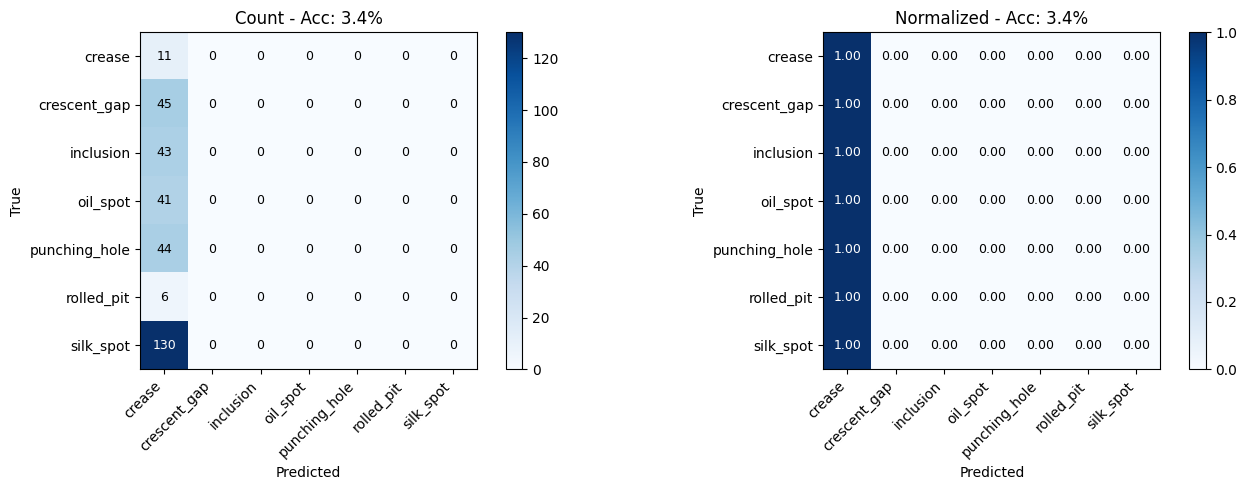

In [6]:
# Eval & confusion matrix
acc = model.evaluate({'image': X_img_test, 'location': X_loc_test}, y_test, verbose=0)[1]
cm = tf.math.confusion_matrix(y_test, model.predict({'image': X_img_test, 'location': X_loc_test}, verbose=0).argmax(1), len(CLASSES)).numpy()
cm_norm = cm / np.maximum(cm.sum(1, keepdims=True), 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, data, title in [(ax1, cm, 'Count'), (ax2, cm_norm, 'Normalized')]:
    im = ax.imshow(data, cmap='Blues')
    ax.set_xticks(range(len(CLASSES))); ax.set_yticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax.set_yticklabels(CLASSES)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_title(f'{title} - Acc: {acc:.1%}')
    for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
            ax.text(j, i, f'{data[i,j]:.0f}' if title=='Count' else f'{data[i,j]:.2f}',
                   ha='center', va='center', color='white' if data[i,j]>data.max()/2 else 'black', fontsize=9)
    plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()


In [7]:
model.save('defect_classifier_model.keras')
